In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

In [3]:
MAKE_ANIMATION = True

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

Epoch     0: mu=[0.51 0.78], sigma=[1.663267731666565, 0.26122191548347473], elbo=-5.04
Epoch   400: mu=[0.5  0.47], sigma=[1.194117784500122, 0.3894125819206238], elbo=-0.29
Epoch   800: mu=[0.49 0.33], sigma=[0.9440600872039795, 0.5786501169204712], elbo=0.52
Epoch  1200: mu=[0.5  0.31], sigma=[0.7921590209007263, 0.8538135290145874], elbo=1.02
Epoch  1600: mu=[0.5  0.29], sigma=[0.6940969228744507, 1.2383610010147095], elbo=1.49
Epoch  2000: mu=[0.5  0.32], sigma=[0.6251030564308167, 1.7344235181808472], elbo=2.04
Epoch  2400: mu=[0.51 0.28], sigma=[0.5781409740447998, 2.2752230167388916], elbo=2.18
Epoch  2800: mu=[0.5 0.3], sigma=[0.5463758707046509, 2.700824499130249], elbo=2.21
Epoch  3200: mu=[0.51 0.3 ], sigma=[0.5254474878311157, 2.919093132019043], elbo=2.24
Epoch  3600: mu=[0.5  0.28], sigma=[0.5112186074256897, 2.982734203338623], elbo=2.24


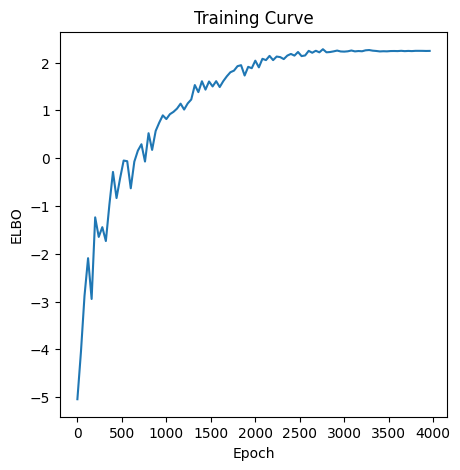

In [4]:
vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5, 3.])
)
vi.run_parameter_optimisation(4000)
fig = vi.plot_training_curve();

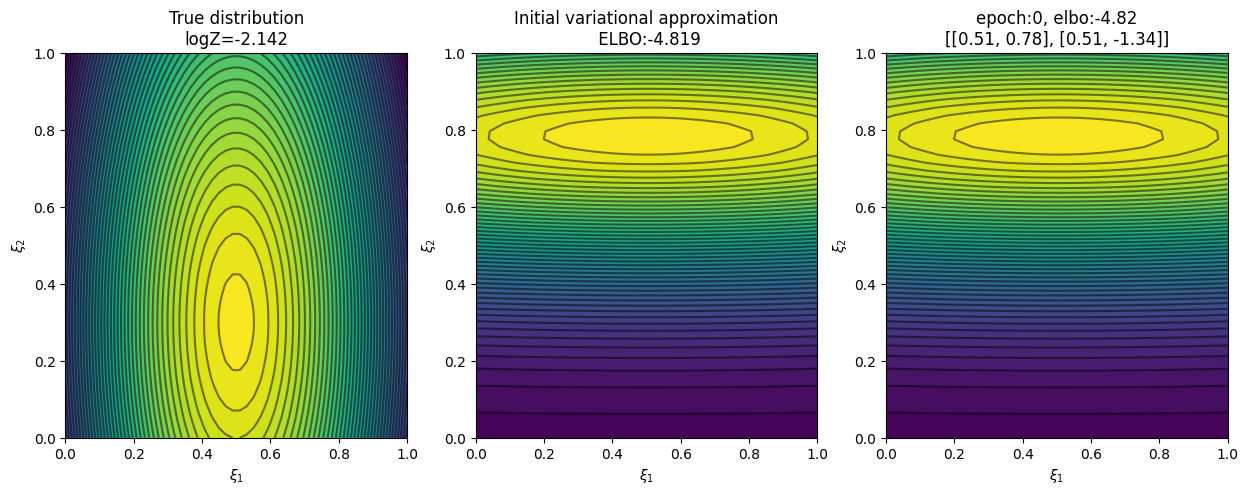

In [7]:
fig, anim = vi.plot_variational_posterior(animate=MAKE_ANIMATION);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))

## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [4]:
# TODO

# Standard Form
We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

lambdas          = [0.14285714 0.4       ]
evidence         = (0.06972903681269418, 1.0165134114625867e-08)
-logZ integrated = 2.6631384509423652
-logZ_approx     = 4.894735916771775
-logZ_...        = 4.894735916771776
-logZ grid sum   = 2.665591701085894
rlct log(n) - (m - 1) log log n         = 0.8878011569174559
RLCT             = 0.14285714285714285
m                = 1
const            = -4.006934759854319
Residue          = -2.23159746582941



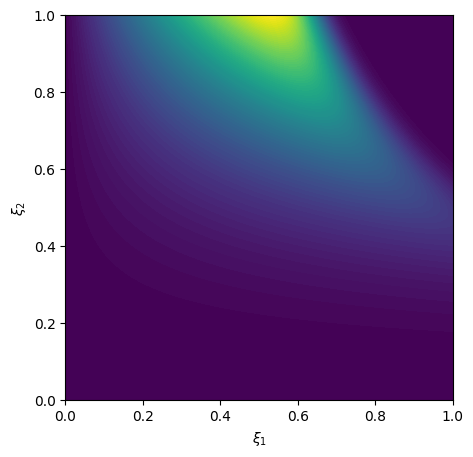

interactive(children=(IntSlider(value=500, description='n', max=100000, min=2), IntSlider(value=7, description…

In [8]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    n=(2, 100000),
    k1=(0, 10),
    k2=(0, 10),
    h1=(0, 10),
    h2=(0, 10)
)
def _plot_contour(n=500, k1=7, k2=5, h1=1, h2=3):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    boltzman_weight = lambda w: np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    integrand = lambda y, x: boltzman_weight(np.array([x, y]))
    z = boltzman_weight(w)
    evidence = scipy.integrate.dblquad(integrand, 0, 1, 0, 1)

    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct)
        - np.sum(np.log(2 * k))
        - np.log(2 * k[1] * (lambdas[1] - lambdas[0]))
    )
#     index = np.argsort(lambdas)[m:]
#     const_term -= np.sum(np.log(2 * k[index]) + np.log(lambdas[index] - rlct))
    
#     if m == 2: 
#         const_term -= np.sum(np.log(k))
#     elif m == 1:
#         i = np.argmin(lambdas)
#         j = np.argmax(lambdas)
#         const_term -= np.log(k[i])
#         const_term -= np.log(lambdas[j] - lambdas[i])
    
    leading_terms = rlct * np.log(n) - (m -1) * np.log(np.log(n))
    print(
        f"lambdas          = {lambdas}\n"
        f"evidence         = {evidence}\n"
        f"-logZ integrated = {-np.log(evidence[0])}\n"
        f"-logZ_approx     = {leading_terms - const_term}\n"
        f"-logZ_...        = {-logZ_approx(k, h, n)}\n"
        f"-logZ grid sum   = {-np.log(normalising_const)}\n"
        f"rlct log(n) - (m - 1) log log n         = {leading_terms}\n"
        
        f"RLCT             = {rlct}\n"
        f"m                = {m}\n"
        f"const            = {const_term}\n"
        f"Residue          = {-np.log(evidence[0]) - leading_terms + const_term}\n"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family



We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\elbo(q_\theta) 
  &= \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

tensor([7., 5.])
tensor([1., 3.])
tensor([0.1429, 0.4000])
logZ=-4.338849784432597
Epoch      0: mu=[0.6 0.9], sigma=[0.09990005195140839, 0.9990004897117615], elbo=-546394944.00
Epoch   4000: mu=[0.38 0.68], sigma=[0.08245500922203064, 0.8251091837882996], elbo=-15370154.00
Epoch   8000: mu=[0.33 0.63], sigma=[0.07941886782646179, 0.7964428663253784], elbo=-43777.91
Epoch  12000: mu=[0.27 0.59], sigma=[0.07621502876281738, 0.7688067555427551], elbo=-3440.25
Epoch  16000: mu=[0.22 0.54], sigma=[0.07299647480249405, 0.7452627420425415], elbo=-99.89
Epoch  20000: mu=[0.19 0.52], sigma=[0.0709812343120575, 0.7311995625495911], elbo=-5.26
Epoch  24000: mu=[0.14 0.49], sigma=[0.06866149604320526, 0.7166159749031067], elbo=-4.91
Epoch  28000: mu=[0.11 0.45], sigma=[0.06693156063556671, 0.7082908749580383], elbo=-5.11
Epoch  32000: mu=[0.07 0.44], sigma=[0.06542007625102997, 0.7001286149024963], elbo=-5.25
Epoch  36000: mu=[0.06 0.41], sigma=[0.06305614113807678, 0.7114667296409607], elbo=-5.

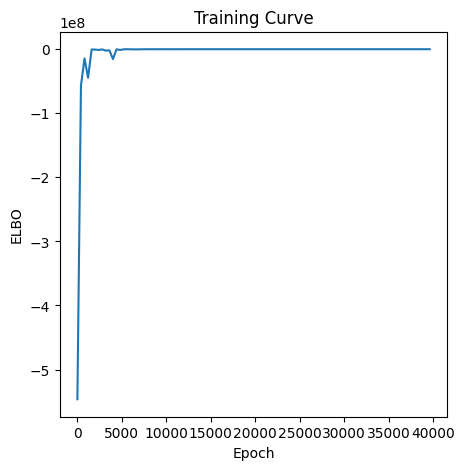

In [9]:
n = 100000000
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)
print(k_0)
print(h_0)
print(lambda_0)


vi = GaussianFamilyOn2DStandardForm(
    n=n,
    k_0=k_0,
    h_0=h_0, 
    lr=0.001, 
    init_mu=torch.tensor([0.6, 0.9]),
    init_logsigma=torch.log(torch.tensor([0.1, 1]))
)
print(f"logZ={vi.log_evidence()}")

vi.run_parameter_optimisation(40000)
fig = vi.plot_training_curve();

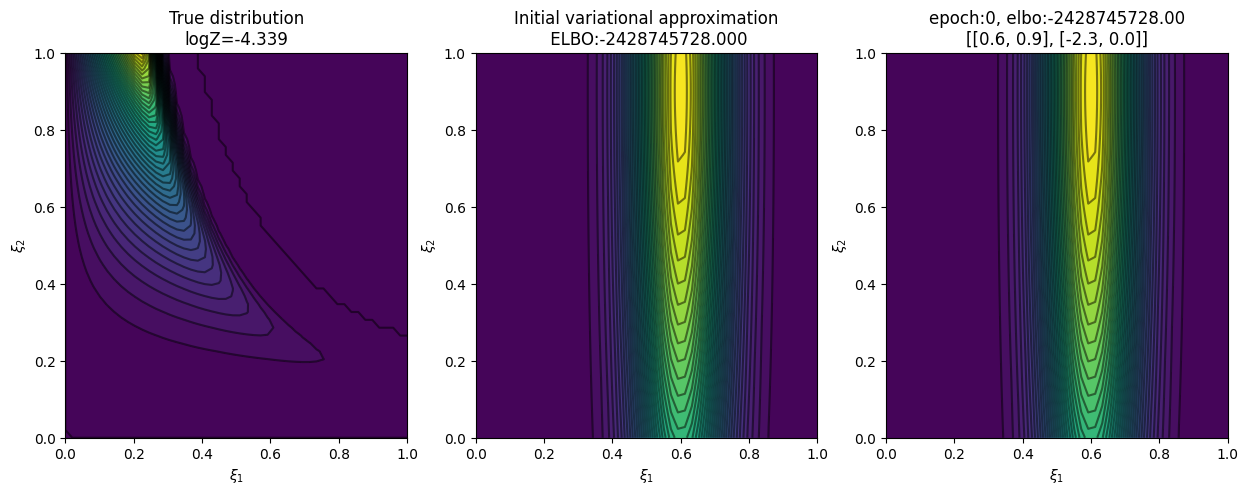

In [10]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("gaussian_on_standard_form.mp4")

# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family and its ELBO
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

The expression for ELBO is given by
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

<p style="color:red;font-size:large">
    Warning: The above expression might not be correct due to the fact that the support of mean-field gamma density is larger than that of the standard form on $[0, 1]^2$
</p>

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j +2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$


# Experiment 2.1: Optimising all parameters ($\lambda$, $k$, $\beta_2$)

Note: 
 * It seems like making $\beta$ really large in the above expression maximises the ELBO expression .. This might be a consequence of the fact that the vairational distribution is not absolutely continuous w.r.t. the posterior ...? 
 * But with $n$ large or $\beta$ large, the constribution outside of the unit cube shouldn't matter much ...? 
 
 
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])

logZ=-2.7502
Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.01, 5.01], betas=[1000.0, 1.0]
Epoch  1000: elbo=-0.63, lambdas=[0.34, 1.5], ks=[2.7, 1.15], betas=[1000.0, 0.3]
Epoch  2000: elbo=12.97, lambdas=[2.56, 7.38], ks=[0.35, 0.31], betas=[1000.0, 0.08]
Epoch  3000: elbo=49.95, lambdas=[16.72, 32.7], ks=[0.06, 0.13], betas=[1000.0, 0.02]
Epoch  4000: elbo=73.78, lambdas=[54.45, 98.22], ks=[0.03, 0.1], betas=[1000.0, 0.01]
Epoch  5000: elbo=76.10, lambdas=[61.41, 185.48], ks=[0.02, 0.11], betas=[1000.0, 0.01]
Epoch  6000: elbo=76.73, lambdas=[61.05, 285.14], ks=[0.02, 0.11], betas=[1000.0, 0.0]
Epoch  7000: elbo=76.95, lambdas=[60.85, 392.98], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  8000: elbo=77.03, lambdas=[60.75, 495.96], ks=[0.02, 0.12], betas=[1000.0, 0.0]
Epoch  9000: elbo=77.05, lambdas=[60.71, 575.07], ks=[0.02, 0.12], betas=[1000.0, 0.0]


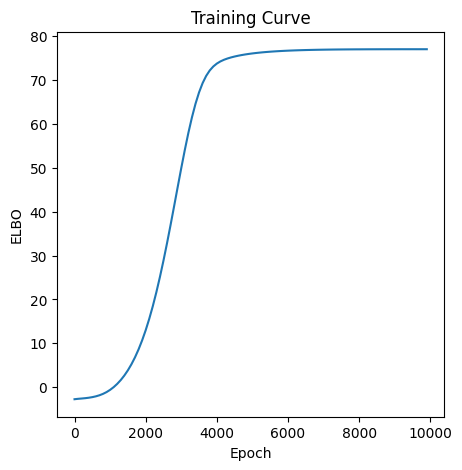

In [11]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
)

vi = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=True, 
    ks_grad=True, 
    beta1_grad=False,
)
print(f"logZ={vi.log_evidence():.4f}")
vi.run_parameter_optimisation(10000)
vi.plot_training_curve();

/Users/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-iNpIuKLj/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-iNpIuKLj/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:135: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/Users/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:156: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/Users/edmund/.local/share/virtualenvs/var

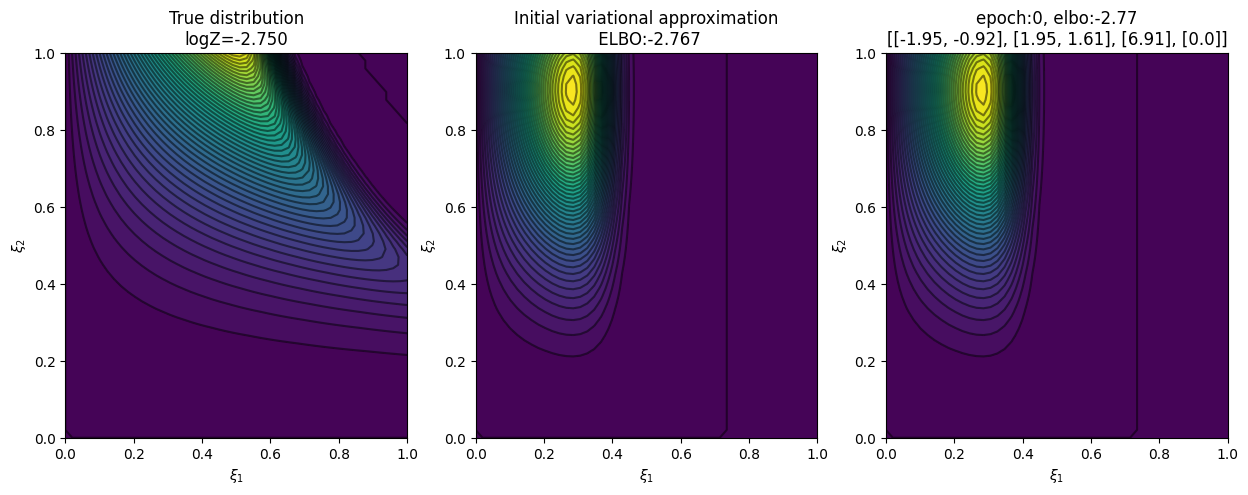

In [12]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))


## Experiment 2.2: Optimising only $\beta_2$
<p style="color:red;font-size:large">
    Warning: While the following run converges, it violates the variational lower bound
</p>

Notes: 
 * It seems like even when the $\lambda$ and $k$ are freezed to the true value, the $\beta$ corresponding to the smallest $\lambda$ goes to $\infty$ while the other one goes to $0$. 

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
h_0      = tensor([1, 3])
logZ=-2.7502

Epoch     0: elbo=-2.77, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 1.0]
Epoch   400: elbo=-2.64, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.67]
Epoch   800: elbo=-2.53, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.46]
Epoch  1200: elbo=-2.44, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.33]
Epoch  1600: elbo=-2.38, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.25]
Epoch  2000: elbo=-2.35, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.19]
Epoch  2400: elbo=-2.34, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.17]
Epoch  2800: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.15]
Epoch  3200: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.15]
Epoch  3600: elbo=-2.33, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[1000.0, 0.14]


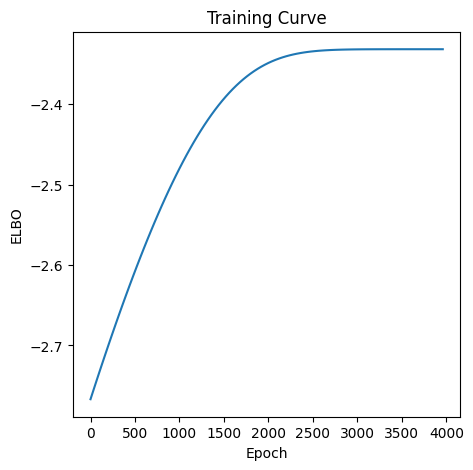

In [13]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}"
)

vi = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False,
)
print(f"logZ={vi.log_evidence():.4f}\n")

vi.run_parameter_optimisation(4000)
vi.plot_training_curve();

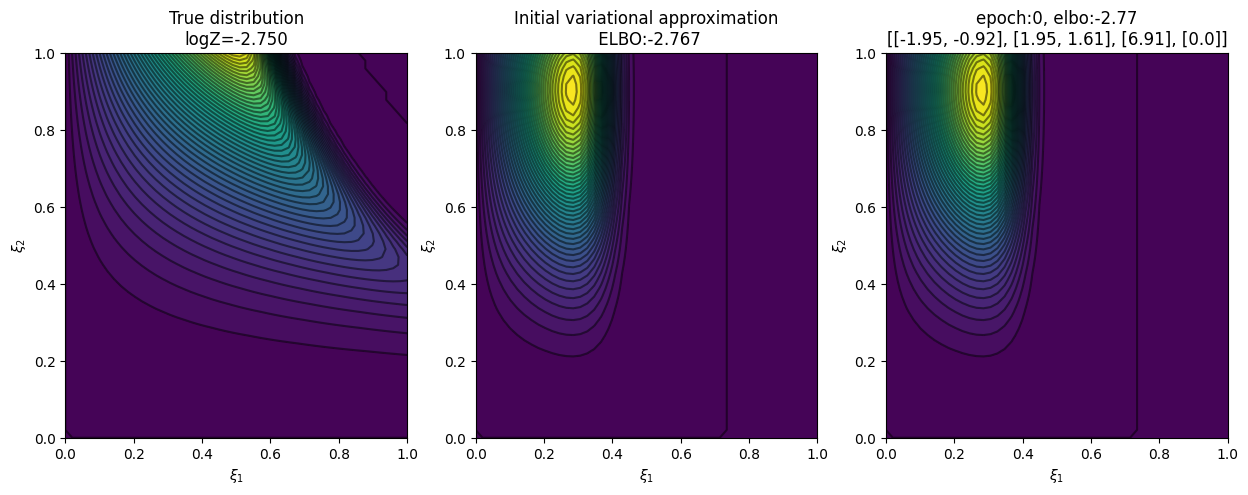

In [14]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))


### Plotting saved snapshots 

In [15]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    snapshot_index=(0, len(meanfield_gamma_restricted_on_standard_form.snapshots) -1)
)
def _plot(snapshot_index=0):
    epoch, parameters, elbo = meanfield_gamma_restricted_on_standard_form.snapshots[snapshot_index]
    lambdas, ks, beta1, beta_rest = [
        torch.exp(param).detach() for param in parameters
    ]
    betas = torch.concat([beta1, beta_rest])
    print(f"Epoch: {epoch}, ELBO: {elbo.item():.3f}")
    print(lambdas, ks, betas)
    print(f"Mean coords: {2 * ks * (betas**lambdas) / torch.exp(torch.lgamma(lambdas))}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = meanfield_gamma_restricted_on_standard_form.variational_density(
        torch.tensor(w), 
        [param.detach() for param in meanfield_gamma_restricted_on_standard_form.parameters]
    )

    ax.contourf(xx, yy, z, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$");

NameError: name 'meanfield_gamma_restricted_on_standard_form' is not defined

# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

ELBO expression: 
<p style="color:red;font-size:large"> TODO </p>

## Experiment 3.1: Optimising only $\beta_2$

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
logZ     = -2.750

Epoch     0: elbo=-3.70, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[499.5, 14.99]
Epoch  1000: elbo=-3.23, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[196.59, 5.67]
Epoch  2000: elbo=-3.02, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[128.47, 2.74]
Epoch  3000: elbo=-2.97, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[158.79, 1.73]
Epoch  4000: elbo=-2.95, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[193.51, 1.22]
Epoch  5000: elbo=-2.95, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[214.2, 0.93]
Epoch  6000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[226.33, 0.77]
Epoch  7000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[233.41, 0.67]
Epoch  8000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[237.08, 0.62]
Epoch  9000: elbo=-2.94, lambdas=[0.14, 0.4], ks=[7.0, 5.0], betas=[238.47, 0.6]


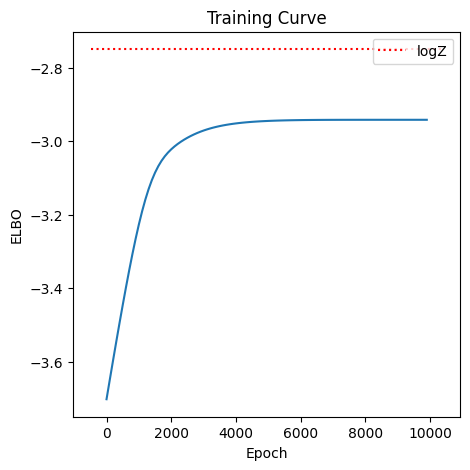

In [16]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)

init_params = [
    lambda_0, 
    k_0, 
    torch.tensor([n - 500, 15])
]
# init_params = None
vi = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=True, 
    init_params=init_params
)

logZ = vi.log_evidence()
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {logZ:.3f}\n"
)


vi.run_parameter_optimisation(10000)
fig = vi.plot_training_curve();
ax = fig.axes[0]
xmin, xmax = ax.get_xlim()
ax.hlines([logZ], xmin, xmax, color="red", linestyle="dotted", label="logZ")
ax.legend()

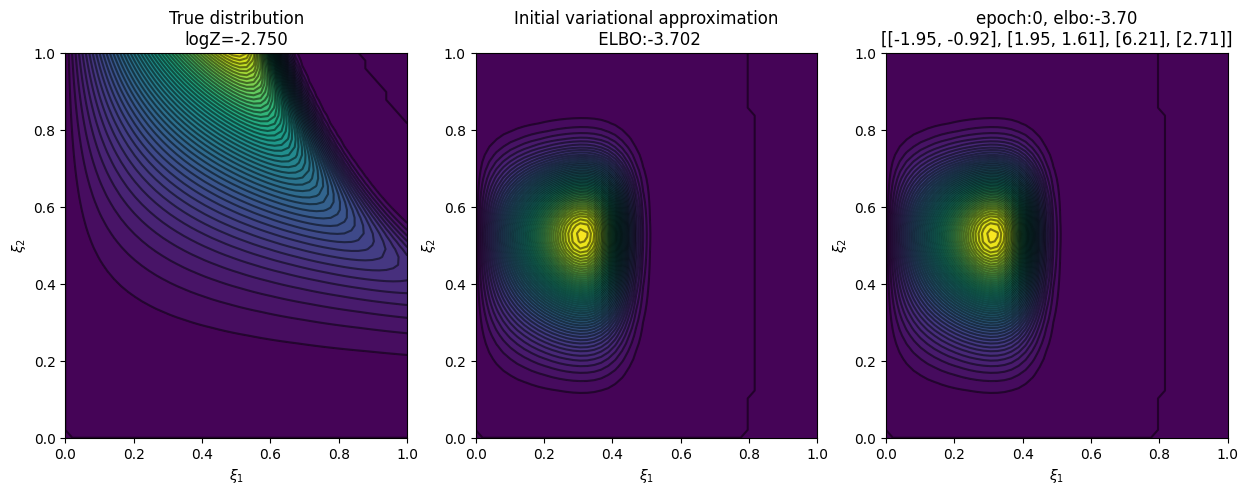

In [17]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_gamma_trunc_optim_beta1_beta2_on_standard_form.mp4")

## Experiment 3.2: Optimising all $\lambda$, $k$, $\beta_2$

<p style="color:red;font-size:large"> 
    WARNING: `igamma` implementation seems to be numerically unstable so this will fail....
</p>

n        = 1000
lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7, 5])
logZ     = -2.750

Epoch     0: elbo=-3.06, lambdas=[0.14, 0.4], ks=[6.99, 5.0], betas=[1000.0, 1.0]
Epoch  1000: elbo=-1.07, lambdas=[0.14, 0.4], ks=[2.67, 1.76], betas=[1000.0, 0.32]
Epoch  2000: elbo=1.02, lambdas=[0.14, 0.4], ks=[0.99, 0.61], betas=[1000.0, 0.14]
Epoch  3000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  4000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  5000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  6000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  7000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  8000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]
Epoch  9000: elbo=nan, lambdas=[0.14, 0.4], ks=[nan, nan], betas=[1000.0, nan]


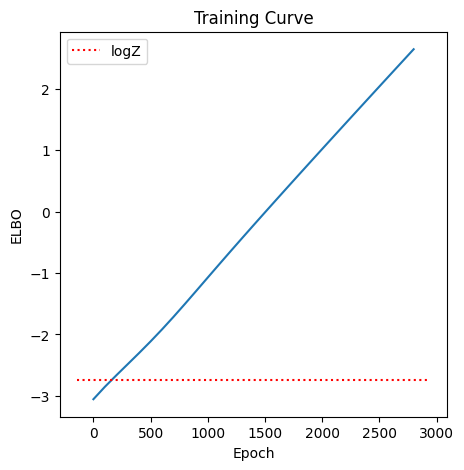

In [18]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1, 3])
lambda_0 = (h_0 + 1) / (2 * k_0)
# init_params = [
#     lambda_0 * 1.3, 
#     k_0 + torch.tensor([9, 2]), 
#     torch.tensor([n, 15])
# ]
init_params = None
vi = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=True, 
    beta1_grad=False, 
    init_params=init_params
)
logZ = vi.log_evidence()
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {logZ:.3f}\n"
)


vi.run_parameter_optimisation(10000)
fig = vi.plot_training_curve();
ax = fig.axes[0]
xmin, xmax = ax.get_xlim()
ax.hlines([logZ], xmin, xmax, color="red", linestyle="dotted", label="logZ")
ax.legend()

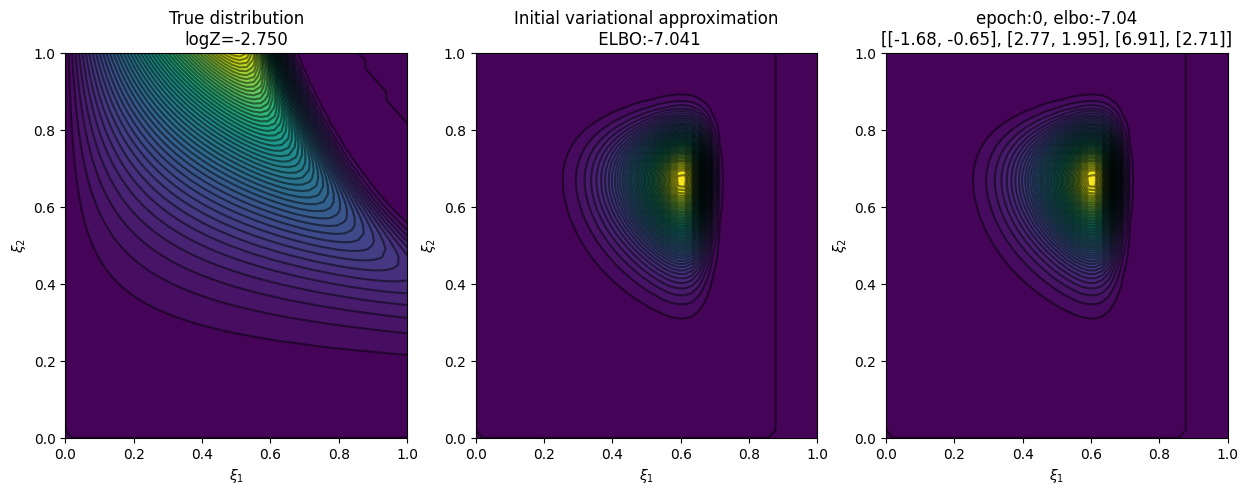

In [125]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_gamma_trunc_on_standard_form.mp4")

# Experiment 4: Mean field Beta family

tensor([7., 5.])
tensor([1., 3.])
tensor([0.1429, 0.4000])
logZ=-3.687747051774602
Epoch      0 -- elbo=-7.11, c1=[1.998 1.998]  , c2=[5.005 3.003]  
Epoch   1000 -- elbo=-6.61, c1=[1.755 2.411]  , c2=[6.427 3.366]  
Epoch   2000 -- elbo=-5.37, c1=[1.847 3.405]  , c2=[7.9   3.245]  
Epoch   3000 -- elbo=-5.69, c1=[2.149 4.565]  , c2=[9.318 3.021]  
Epoch   4000 -- elbo=-4.60, c1=[2.511 5.561]  , c2=[10.587  2.78 ]
Epoch   5000 -- elbo=-4.42, c1=[2.983 6.17 ]  , c2=[12.133  2.545]
Epoch   6000 -- elbo=-4.34, c1=[3.687 6.281]  , c2=[13.925  2.313]
Epoch   7000 -- elbo=-4.28, c1=[4.517 6.112]  , c2=[15.81   2.017]
Epoch   8000 -- elbo=-4.28, c1=[5.393 5.522]  , c2=[18.129  1.732]
Epoch   9000 -- elbo=-4.18, c1=[6.394 4.922]  , c2=[20.463  1.475]


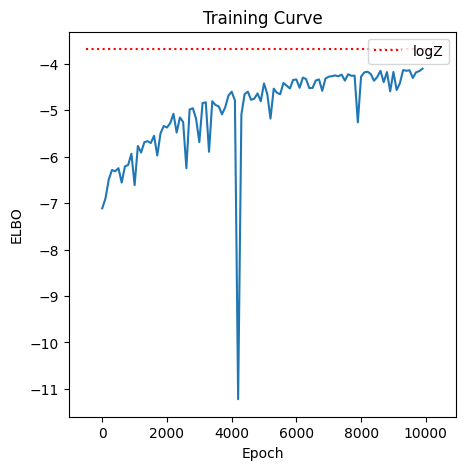

In [19]:
n = 1000000
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)
print(k_0)
print(h_0)
print(lambda_0)


vi = MeanFieldBetaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    init_params=[
        torch.tensor([2, 2]), 
        torch.tensor([5, 3])
    ]
)
logZ = vi.log_evidence()
print(f"logZ={logZ}")

vi.run_parameter_optimisation(10000)
fig = vi.plot_training_curve();
ax = fig.axes[0]
xmin, xmax = ax.get_xlim()
ax.hlines([logZ], xmin, xmax, color="red", linestyle="dotted", label="logZ")
ax.legend()

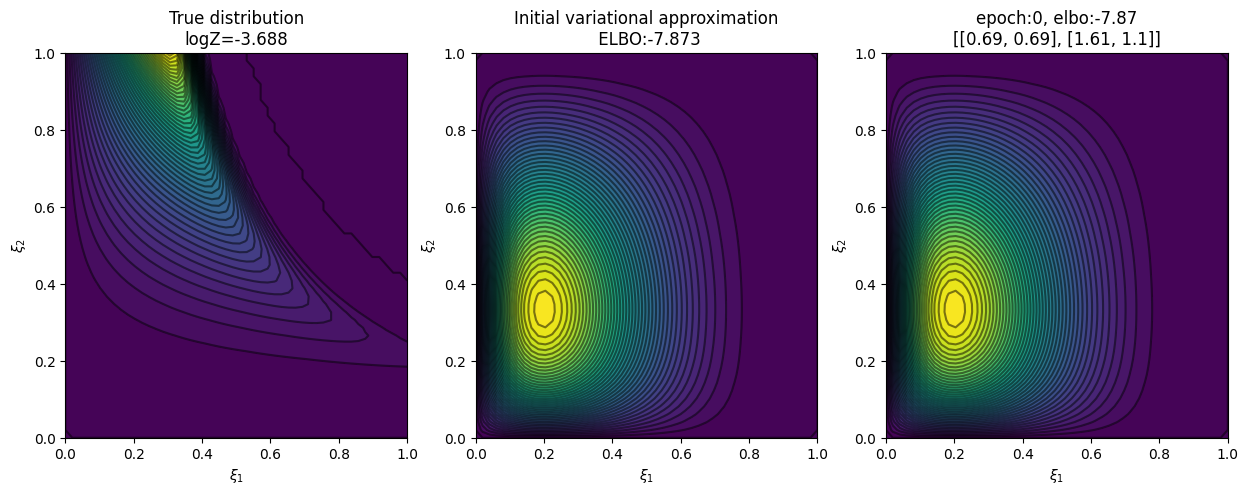

In [20]:
fig, anim = vi.plot_variational_posterior(animate=True);
if anim is not None:
    video = anim.to_html5_video()
    IPython.display.display(IPython.display.HTML(video))
# anim.save("mf_beta_on_standard_form.mp4")

# Experiment X: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family